<a href="https://colab.research.google.com/github/jatin-reddy/CNNs-for-Computer-Vision/blob/main/CNN_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moritzm00/utkface-cropped")

print("Path to dataset files:", path)

100%|██████████| 116M/116M [00:06<00:00, 18.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1


Skipping file with ValueError: 61_1_20170109150557335.jpg.chip.jpg
Skipping file with ValueError: 39_1_20170116174525125.jpg.chip.jpg
Skipping file with ValueError: 61_1_20170109142408075.jpg.chip.jpg


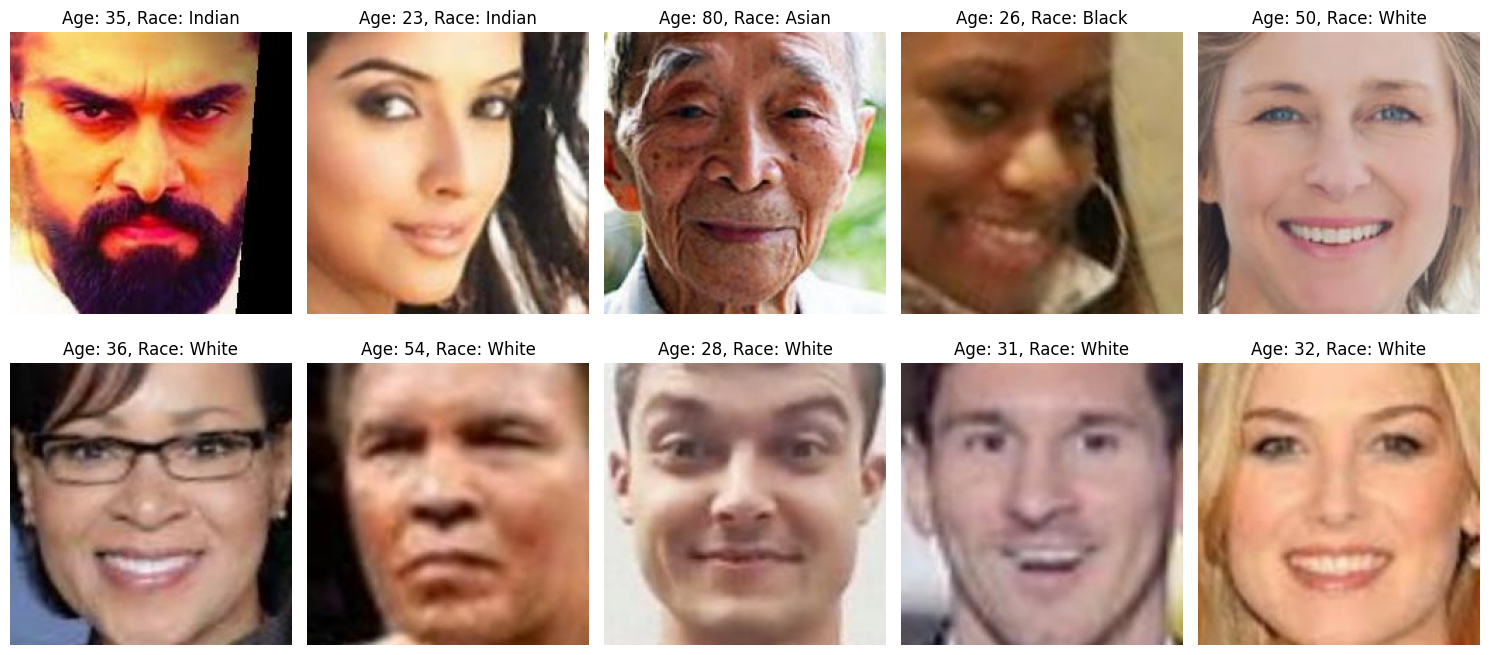

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

dataset_path = "/root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1"
dataset_path = os.path.join(dataset_path, "UTKFace")

# image_paths, age, gender, race
image_paths = []
age_list = []
gender_list = []
race_list = []

race_dict = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

gender_dict = {
    0: 'Male',
    1: 'Female',
}

for images in os.listdir(dataset_path):
    if images.endswith(".jpg"):
        try:
            image_name = os.path.basename(images)
            image_path = os.path.join(dataset_path, image_name)
            image_labels = image_name.split('_')

            age = int(image_labels[0])
            gender = int(image_labels[1])
            race = int(image_labels[2])

            age_list.append(age)
            gender_list.append(gender)
            race_list.append(race)
            image_paths.append(image_path)

        except ValueError:
            print(f"Skipping file with ValueError: {image_name}")
        except IndexError:
            print(f"Skipping file with IndexError: {image_name}")
        except Exception as e:
            print(f"Skipping file with unknown error '{e}': {image_name}")

## Displaying random images with ethnicity and age
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i in range(10):
    idx = random.randint(0, len(image_paths) - 1)

    img_path = image_paths[idx]
    age = age_list[idx]
    race = race_list[idx]

    ax = axes[i // 5, i % 5]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Age: {age}, Race: {race_dict.get(race, 'Unknown')}")
    ax.axis('off')

plt.tight_layout()
plt.show()

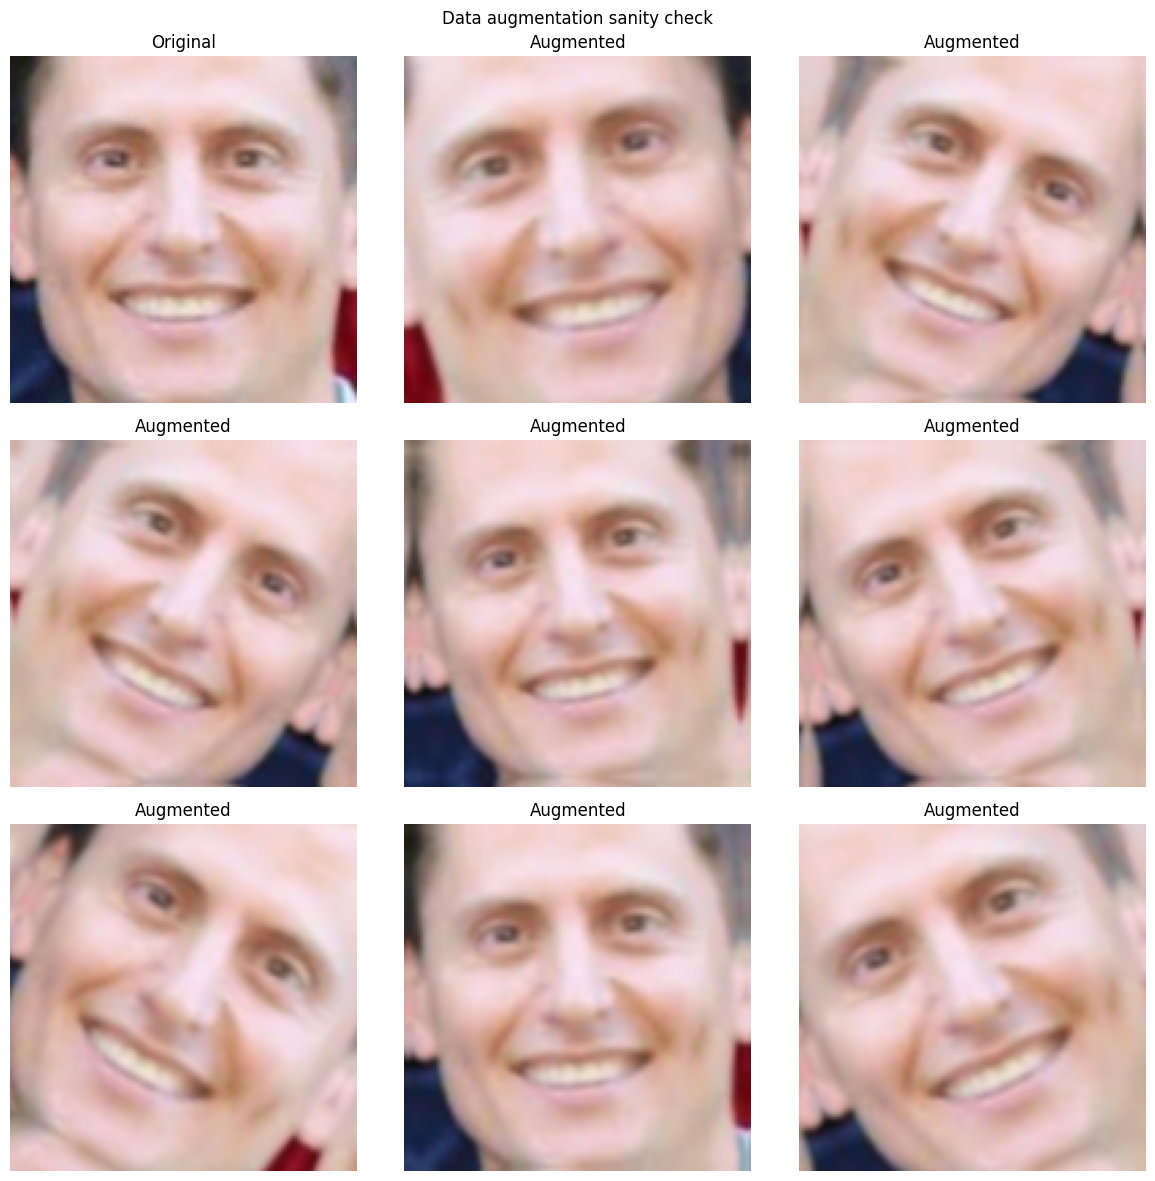

In [19]:
# Data Augmentation
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

IMG_SIZE = 128
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #layers.RandomBrightness(factor=0.2),
        #layers.RandomContrast(factor=0.2),
    ],
    name="data_augmentation"
)

img = tf.io.read_file(image_paths[0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
img_batch = tf.expand_dims(img, 0)

plt.figure(figsize=(12, 12))
ax = plt.subplot(3, 3, 1)
plt.imshow(img.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

for i in range(8):
    ax = plt.subplot(3, 3, i + 2)
    augmented_batch = data_augmentation(img_batch, training=True)
    augmented_img = augmented_batch[0]

    plt.imshow(augmented_img.numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Data augmentation sanity check", fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
# image_paths, age_list, gender_list, race_list

max_age = 116.0
age_list_normalized = [age / max_age for age in age_list]

# Test-Val_test split: 60% Train, 20% Val, 20% Test

# 60% Train, 40% Temp
(train_paths, temp_paths,
 train_ages, temp_ages,
 train_gender, temp_gender,
 train_races, temp_races) = train_test_split(
    image_paths,
    age_list_normalized,
    gender_list,
    race_list,
    test_size=0.4,
    random_state=42,
    stratify=race_list
)

# Temp to 20% Val, 20% Test
(val_paths, test_paths,
 val_ages, test_ages,
 val_gender, test_gender,
 val_races, test_races) = train_test_split(
    temp_paths,
    temp_ages,
    temp_gender,
    temp_races,
    test_size=0.5,
    random_state=42,
    stratify=temp_races
)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(race_list)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_races
)

race_weights_dict = dict(zip(classes, weights))
race_weights_dict = {int(i): float(j) for i, j in race_weights_dict.items()}

print("Class Weights for Ethnicity:")
print(race_weights_dict)

train_race_weights = [race_weights_dict[label] for label in train_races]
val_race_weights = [1.0] * len(val_paths)
test_race_weights = [1.0] * len(test_paths)


Class Weights for Ethnicity:
{0: 0.47041508185877295, 1: 1.0473490427098675, 2: 1.380873786407767, 3: 1.1927044025157232, 4: 2.80256157635468}


In [8]:
IMG_SIZE = 128
BATCH_SIZE = 64
# function for image loading and preprocessing
def load_preprocess(image_path, age_label, gender_label, race_label, race_weight):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    """
    labels = {
        "age_output": age_label,
        "gender_output": gender_label,
        "ethnicity_output": race_label
    }

    weights = {
        "age_output": 1.0,
        "gender_output": 1.0,
        "ethnicity_output": race_weight ### key error
    }
    """
    labels = (age_label, gender_label, race_label)
    # (age weight, genderweight, race weight)
    weights = (1.0, 1.0, race_weight)

    return img, labels, weights ### bug (forgot to add weights)

# data loading pipepline
def data_pipeline(paths, ages, gender, races, race_weights, is_training=True):

    df = tf.data.Dataset.from_tensor_slices((paths, ages, gender, races, race_weights))

    df = df.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        df = df.shuffle(buffer_size=1000)

    df = df.batch(BATCH_SIZE)
    df = df.prefetch(buffer_size=tf.data.AUTOTUNE)

    return df

train_df = data_pipeline(train_paths, train_ages, train_gender, train_races, train_race_weights)
val_df = data_pipeline(val_paths, val_ages, val_gender, val_races, val_race_weights, is_training=False)
test_df = data_pipeline(test_paths, test_ages, test_gender, test_races, test_race_weights, is_training=False)

We can clearly see that this simple model architecture (even with class_weight adjustments, loss_weight adjustments and an addition of batch normalisation) isn;t learning on ethnicities. So, all of these point to a problem in the model architecture itself. Let's change things up. (Till here, I thought the model architecture was the issue)

Update:
From last commit, through trial and error it was found that
sample_weights weren't passed in the data pipeline which uncovered a bug in this section (tuples instead of dict was passed to solve this).

Secondly, when I normalising pixels/255 and then passing Random brightness and Random Contrast in the data augmentation step, the model was getting pure white/black images because of the 0.2 shift in (0,1) range.

In [11]:
keras.utils.clear_session()

# Model 1: simple_model.keras

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

age_output = layers.Dense(1, activation='sigmoid', name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(x)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'age_output': 'mean_squared_error',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },
    loss_weights={'age_output': 1.0, 'gender_output': 1.0, 'ethnicity_output': 1.0}
)

print("Starting Final Training Run...")
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='simple_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(
    train_df,
    epochs=40,
    validation_data=val_df,
    callbacks=[early_stopping, model_checkpoint]
)

Starting Final Training Run...
Epoch 1/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - age_output_loss: 0.0339 - age_output_mean_absolute_error: 0.1415 - ethnicity_output_accuracy: 0.3393 - ethnicity_output_loss: 1.5253 - gender_output_accuracy: 0.6274 - gender_output_loss: 0.6401 - loss: 2.1993 - val_age_output_loss: 0.0613 - val_age_output_mean_absolute_error: 0.1958 - val_ethnicity_output_accuracy: 0.1578 - val_ethnicity_output_loss: 2.2986 - val_gender_output_accuracy: 0.4929 - val_gender_output_loss: 1.0018 - val_loss: 3.3603
Epoch 2/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - age_output_loss: 0.0253 - age_output_mean_absolute_error: 0.1237 - ethnicity_output_accuracy: 0.4149 - ethnicity_output_loss: 1.4229 - gender_output_accuracy: 0.6962 - gender_output_loss: 0.5776 - loss: 2.0258 - val_age_output_loss: 0.0418 - val_age_output_mean_absolute_error: 0.1562 - val_ethnicity_output_accuracy: 0.2767 - val_ethnicity_output_loss: 1.7180 - val_gender_output_accuracy: 0.6092 - val_g

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 1,371,863 (5.23 MB)

 Trainable params: 456,967 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 913,936 (3.49 MB)

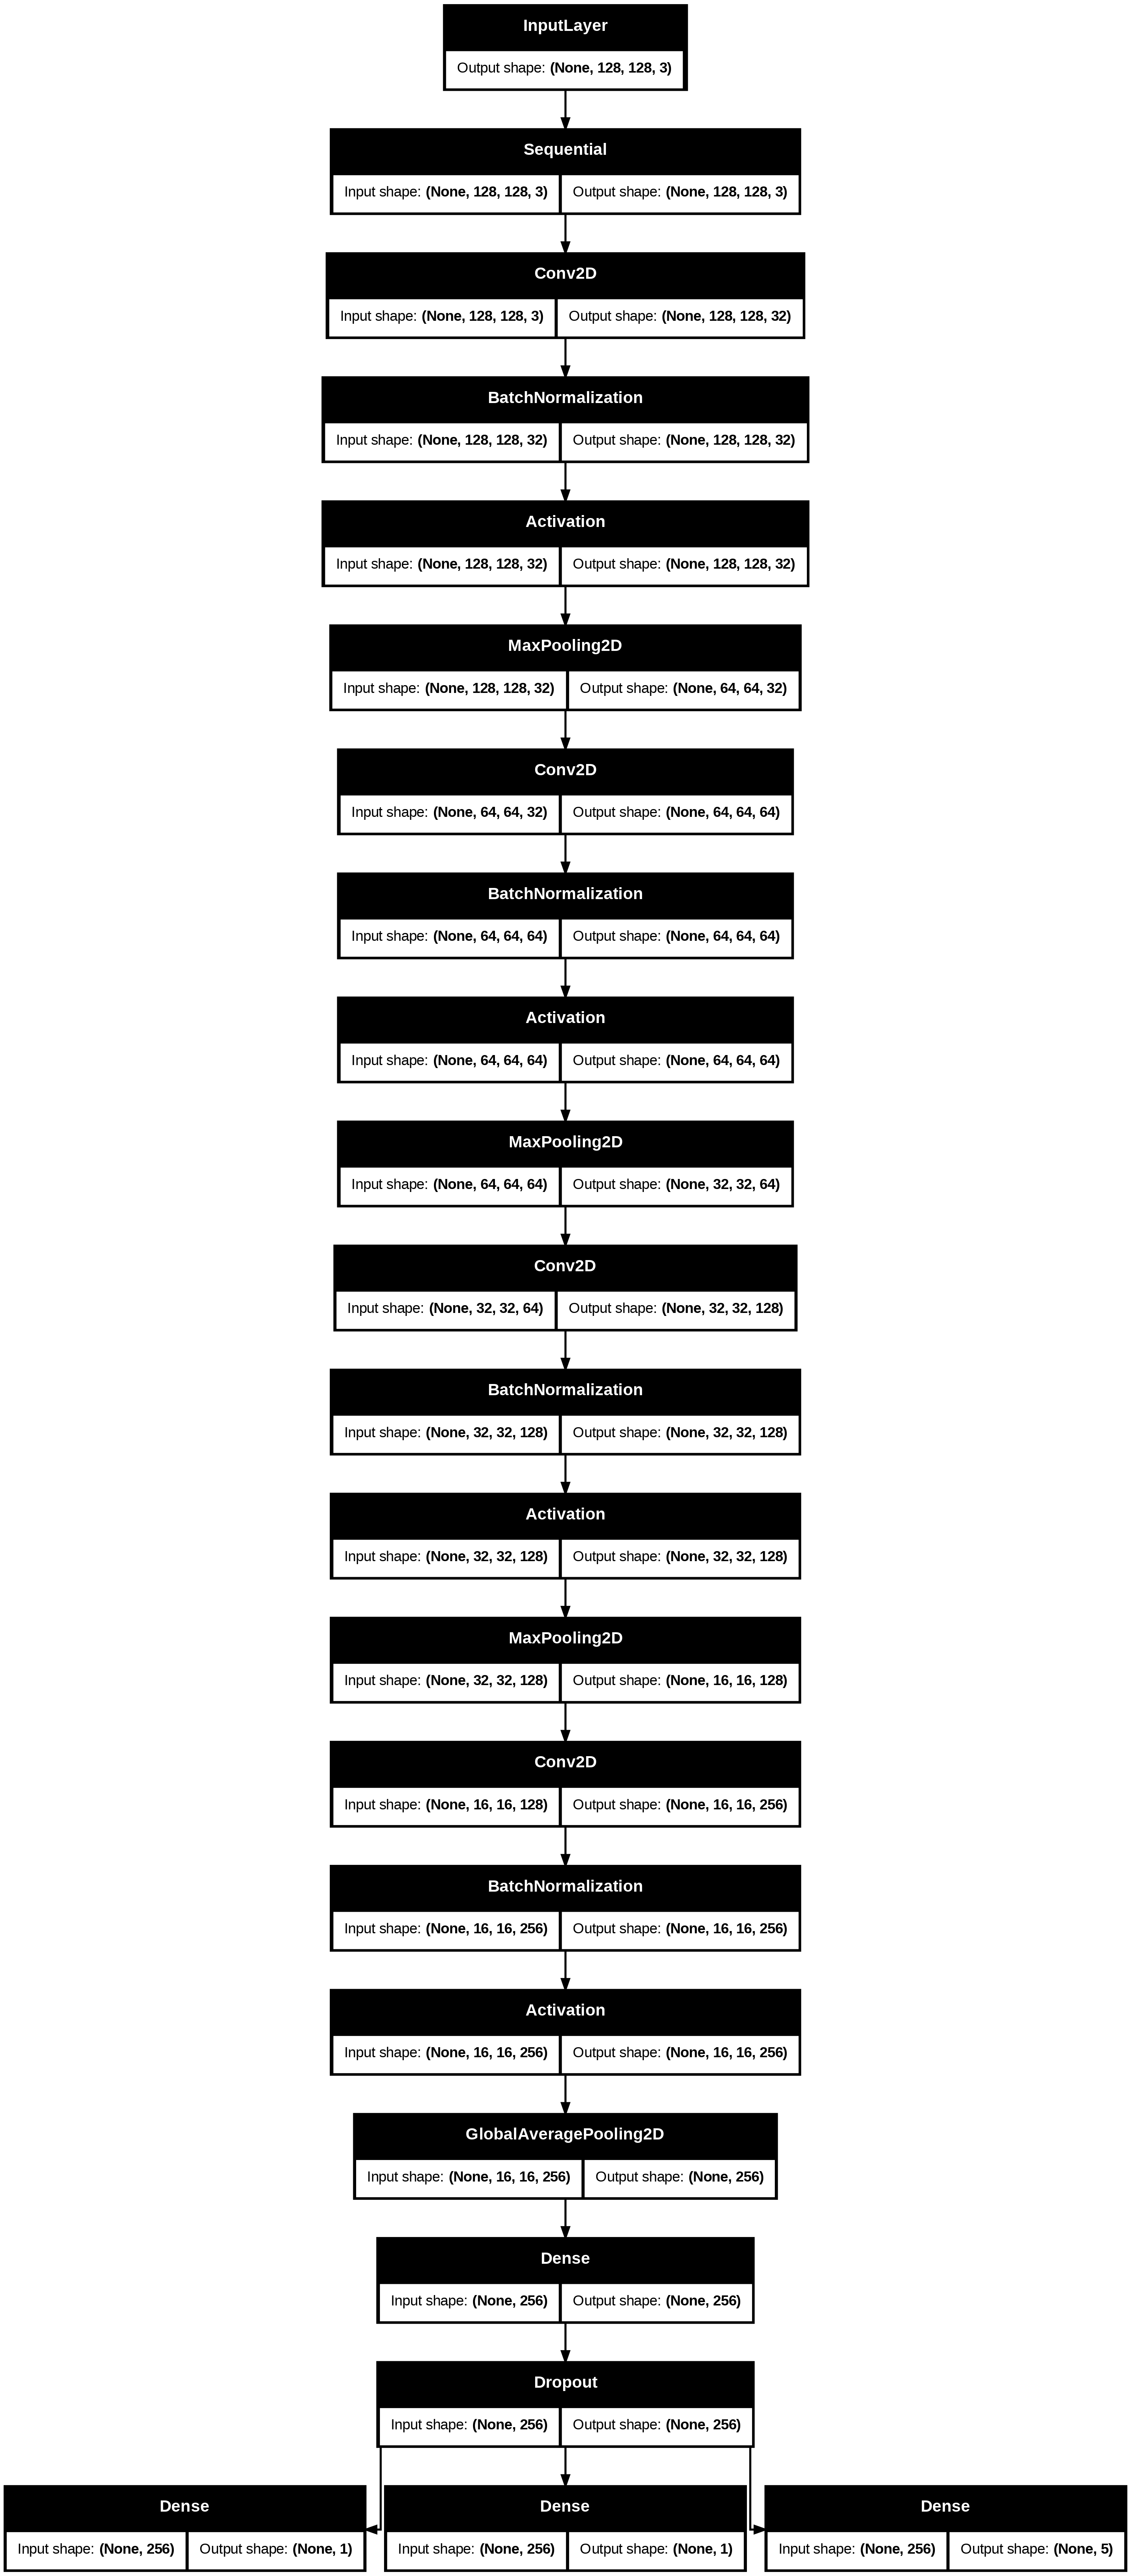

In [16]:
keras.utils.plot_model(model, show_shapes=True)

In [20]:
import keras
keras.utils.clear_session(free_memory=True)


In [21]:
from keras import layers, models, callbacks

def vgg_block(x, filters):
  #conv-conv-pool
  x = layers.Conv2D(filters, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.25)(x)

  return x

# Model 2 (VGG Inspired)
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = vgg_block(x, 32)
x = vgg_block(x, 64)
x = vgg_block(x, 128)
x = vgg_block(x, 256)
x = vgg_block(x, 512)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# Age (Regression)
age_fcl = layers.Dense(256, activation='relu')(x)
age_output = layers.Dense(1, activation='sigmoid', name='age_output')(age_fcl)

# Gender (Classification)
gender_fcl = layers.Dense(64, activation='relu')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_fcl)

# Ethnicity (Classification)
ethnicity_fcl = layers.Dense(512, activation='relu')(x)
ethnicity_fcl = layers.Dropout(0.5)(ethnicity_fcl)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(ethnicity_fcl)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),

    loss={
        'age_output': 'mean_squared_error',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },

    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },

    loss_weights={
        'age_output': 1.0,
        'gender_output': 1.0,
        'ethnicity_output': 1.0
    }
)
print("Model compiled for 3 outputs.")

model.summary()

Model compiled for 3 outputs.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][

 Total params: 13,965,479 (53.27 MB)

 Trainable params: 13,961,511 (53.26 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [22]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='vgg_model.keras', monitor='val_loss', save_best_only=True)

# Training
print("Starting training")
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=[early_stopping, model_checkpoint])
print("Training complete.")

# Testing
print("\nEvaluating on unseen test data ---")
test_metrics = model.evaluate(test_df)
print(f"Test Metrics: {test_metrics}")

Starting training
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 72s 265ms/step - age_output_loss: 0.0531 - age_output_mean_absolute_error: 0.1816 - ethnicity_output_accuracy: 0.2515 - ethnicity_output_loss: 2.1408 - gender_output_accuracy: 0.5570 - gender_output_loss: 0.7471 - loss: 2.9411 - val_age_output_loss: 0.0295 - val_age_output_mean_absolute_error: 0.1312 - val_ethnicity_output_accuracy: 0.1449 - val_ethnicity_output_loss: 1.6803 - val_gender_output_accuracy: 0.5187 - val_gender_output_loss: 0.7058 - val_loss: 2.4156
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - age_output_loss: 0.0324 - age_output_mean_absolute_error: 0.1420 - ethnicity_output_accuracy: 0.2932 - ethnicity_output_loss: 1.5780 - gender_output_accuracy: 0.6666 - gender_output_loss: 0.6185 - loss: 2.2289 - val_age_output_loss: 0.0286 - val_age_output_mean_absolute_error: 0.1281 - val_ethnicity_output_accuracy: 0.1704 - val_ethnicity_output_loss: 1.6442 - val_gender_output_accuracy: 0.5193 - val_gender_output_